#  SeismicHunt getting started on Colab

### Author: M. Ravasi

Welcome to the first **KAUST Hackathon in Geoscience** and congratulations for being one of the selected partecipants!

This notebook is intended to serve as a starting point for the SeismicHunt project.

**Project description:**

The Earth is filled with an invaluable amount of resources that power our daily lives. Natural gas, for example, is going to play a key role in the energy transition as its use is required to produce blue hydrogen. Nevertheless finding such resources is hard and geoscientists play a constant treasure hunt when interpreting seismic data. We wish therefore to devise an artificially intelligent tool that provided with a large set of unlabeled seismic pre-stack data and a small labeled dataset can detect residual gas accumulation in the subsurface (and possibly their shape and saturation).

**Dataset**:

We have created for you a number of synthetic seismic pre-stack datasets based on different geological models. To mimic a real-life scenario, the provide dataset comprises of:

- a small number of labelled training data ($N_{labeled}=X$): this is intended to mimic datasets that have been interpreted by experts and where a positive (or negative) outcome has been reported by drilling a well. Inputs are pre-stack seismic data of size $(4 \times 128 \times 128)$, i.e. 4 angles, and 128 samples in both the depth and horizonal spatial axes. Labels are provided in the form of gas saturation *maps* of the same size of the corresponding input.

- a large number of labelled training data ($N_{unlabelled}=X$): this is intended to mimic other seismic datasets in the same area that have not been interpreted or whose corresponding gas saturation is highly uncertain. You may want to use these data to train your model in a semi-supervised fashion if the limited number of labelled training data leads to poor performance of classical supervised approaches.

- a seismic dataset for testing purposes: in this case we provide an entire seismic section from one of most famous open-source models, the X model. We expect you to divide this section into patches (you will choose which strategy to us), apply your trained model, and provide a gas saturation map of the entire area.

*NOTE*: we finally want to bring to your attention a couple of choices that we made during the generation of the training dataset to mimic once again what you are likely to expect in real life:

- All datasets are modelled using a Ricker wavelet with randomly selected frequency in the range of 6 to 8 Hz;
- All datasets are contaminated with spatially colored noise with randomly selected standard deviation in the range of 1e-1-4e-1;
- All datasets are modelled using the Aki-Richards approximation of the Zoeppritz equation and contain 4 angles (0, 15, 30, 45) degrees;


**Getting started**

First of all, you will need to access the dataset. If you are working on Colab simply head [here](https://drive.google.com/drive/folders/1t0JR9LWIerP2V12PN84O_1Ri__SHTOZ4?usp=sharing), download the dataset and place it in your GDrive.

In the following we provide a number of routines to load and visualize the training data (both input and labels) that you may find useful along the way to investigate the data as well as evaluate your predictions.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import glob
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from matplotlib.colors import LinearSegmentedColormap

In [2]:
def _wiggletrace(ax, tz, trace, center=0, cpos='r', cneg='b'):
    """Plot a seismic wiggle trace onto an axis
    Parameters
    ----------
    ax : :obj:`plt.axes`, optional
         Axes handle
    tz : :obj:`np.ndarray `
        Depth (or time) axis
    trace : :obj:`np.ndarray `
        Wiggle trace
    center : :obj:`float`, optional
        Center of x-axis where to switch color
    cpos : :obj:`str`, optional
        Color of positive filling
    cneg : :obj:`str`, optional
        Color of negative filling
    Returns
    -------
    ax : :obj:`plt.axes`, optional
         Axes handle
    """
    if cpos is not None:
        ax.fill_betweenx(tz, center, trace, where=(trace > center),
                         color=cpos, interpolate=True)
    if cneg is not None:
        ax.fill_betweenx(tz, center, trace, where=(trace <= center),
                         color=cneg, interpolate=True)
    ax.plot(trace, tz, 'k', lw=1)
    return ax


def wiggletracecomb(ax, tz, x, traces, scaling=None,
                    cpos='r', cneg='b'):
    """Plot a comb of seismic wiggle traces onto an axis
    Parameters
    ----------
    ax : :obj:`plt.axes`, optional
         Axes handle
    tz : :obj:`np.ndarray `
        Depth (or time) axis
    x : :obj:`np.ndarray `
        Lateral axis
    traces : :obj:`np.ndarray `
        Wiggle traces
    scaling : :obj:`float`, optional
        Scaling to apply to each trace
    cpos : :obj:`str`, optional
        Color of positive filling
    cneg : :obj:`str`, optional
        Color of negative filling
    Returns
    -------
    ax : :obj:`plt.axes`, optional
         Axes handle
    """
    dx = np.abs(x[1]-x[0])
    tracesmax = np.max(traces, axis=1)
    tracesmin = np.min(traces, axis=1)
    dynrange = tracesmax - tracesmin
    maxdynrange = np.max(dynrange)
    if scaling is None:
        scaling = 2*dx/maxdynrange
    else:
        scaling = scaling*2*dx/maxdynrange

    for ix, xx in enumerate(x):
        trace = traces[ix]
        _wiggletrace(ax, tz, xx + trace * scaling, center=xx,
                     cpos=cpos, cneg=cneg)
    ax.set_xlim(x[0]-1.5*dx, x[-1]+1.5*dx)
    ax.set_ylim(tz[-1], tz[0])
    ax.set_xticks(x)
    ax.set_xticklabels([str(xx) for xx in x])

    return ax


cmap_water_gas = LinearSegmentedColormap.from_list('name', ['r', 'b'])

cmap_seismic = \
    LinearSegmentedColormap.from_list('name',
                                      list(['#33ffff', '#33adff',
                                            '#0000ff', '#666666',
                                            '#d9d9d9', '#805500',
                                            '#ff6600', '#ffdb4d',
                                            '#ffff00']))

# Connect to GDRIVE

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
datapath = '/content/gdrive/MyDrive/SeismicHunt/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Training data

### Labelled

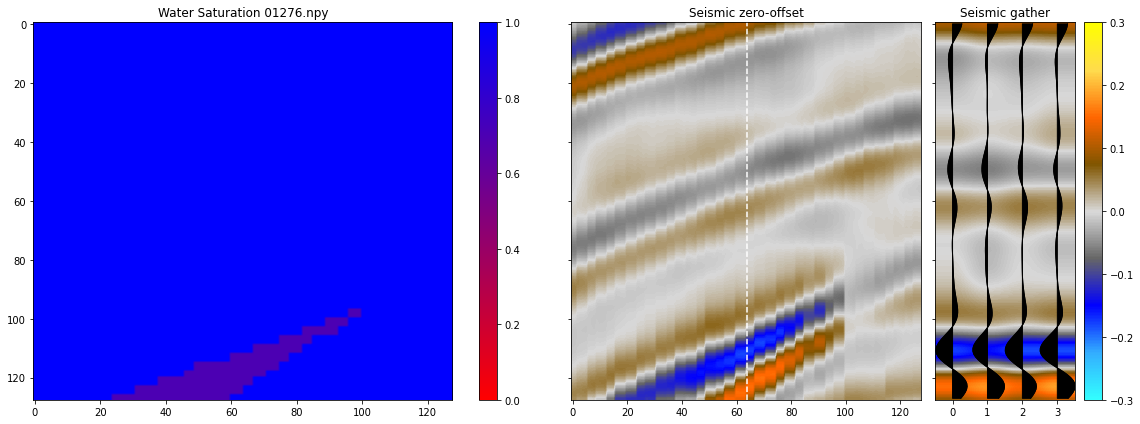

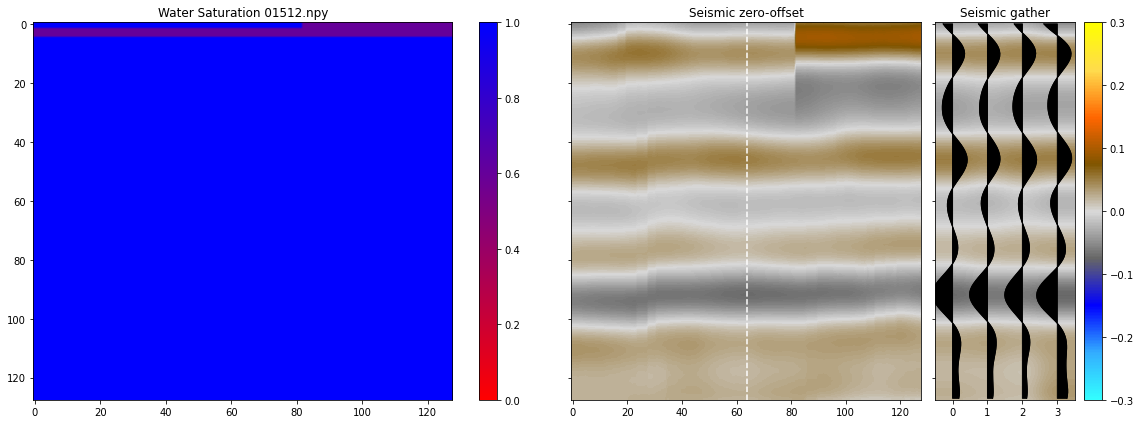

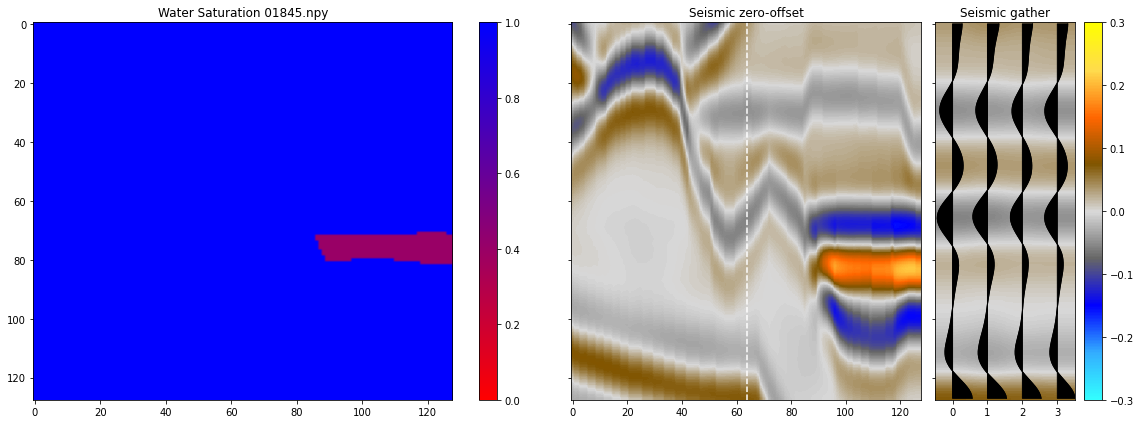

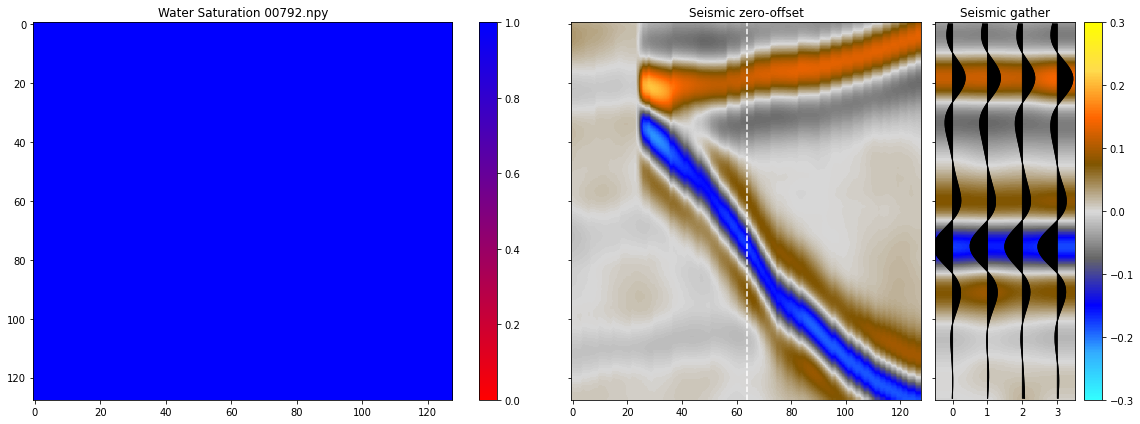

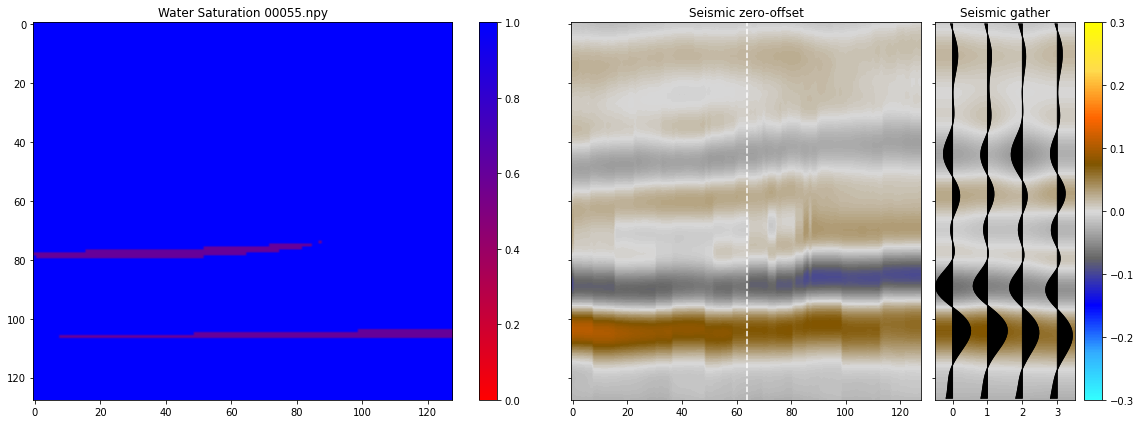

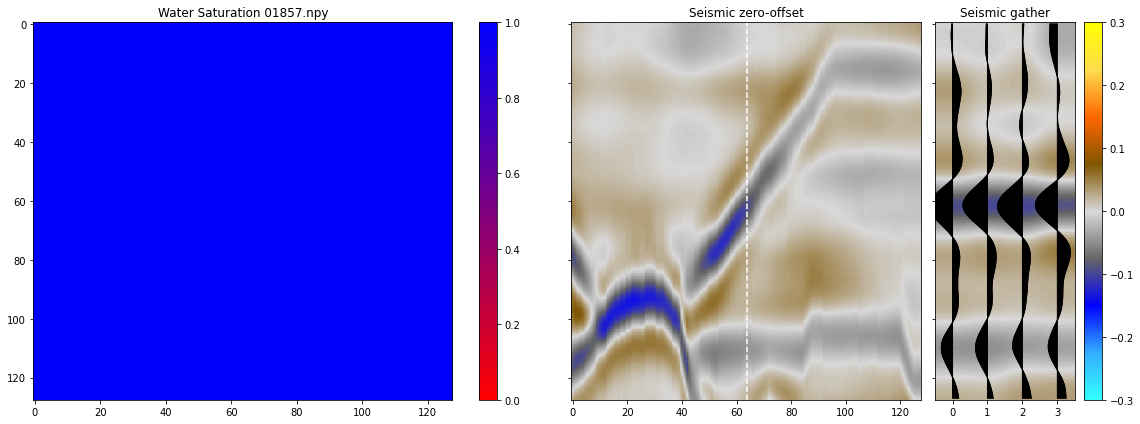

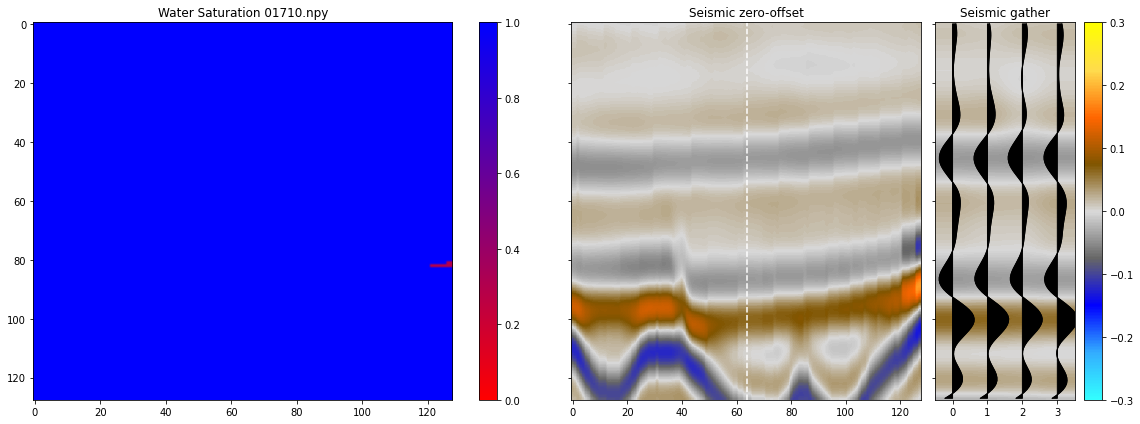

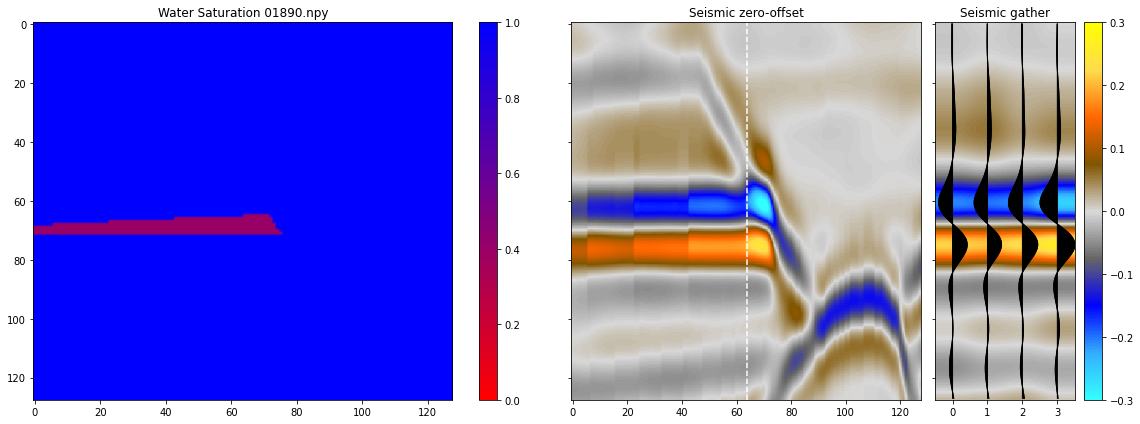

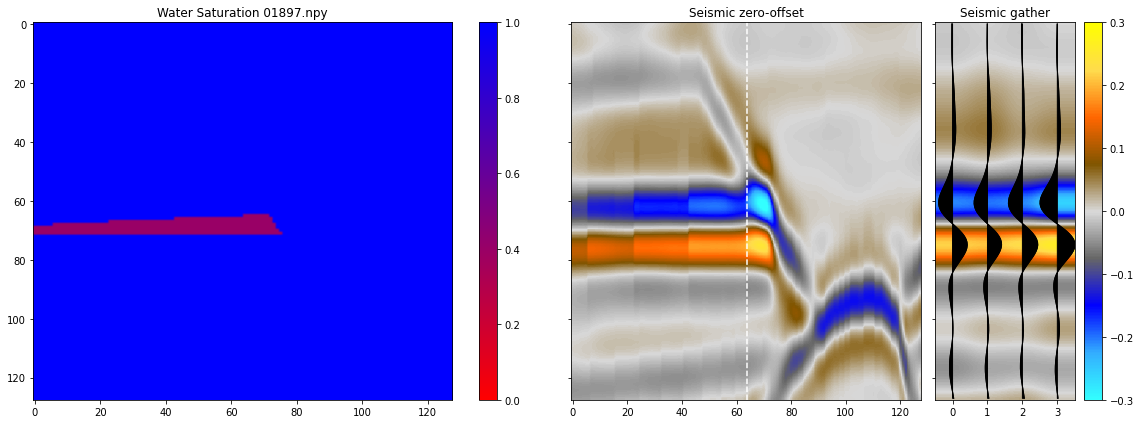

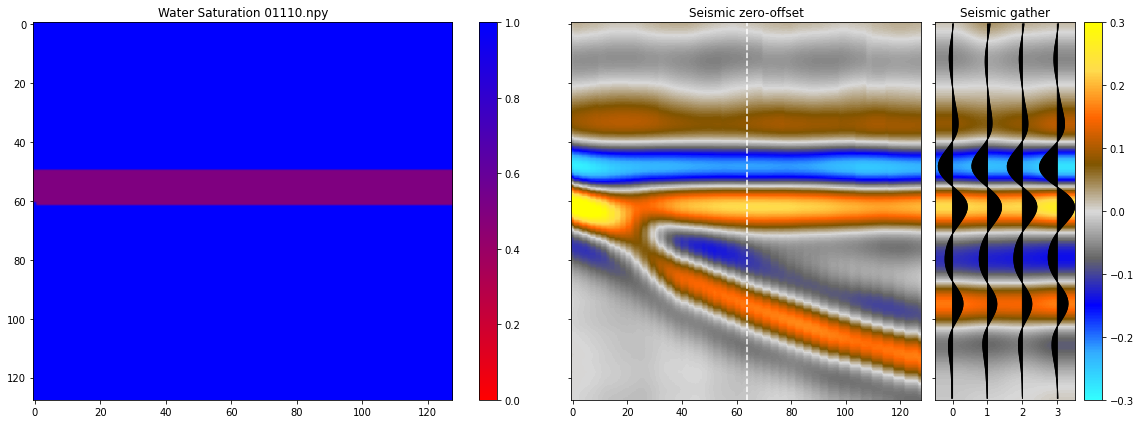

In [4]:
np.random.seed(5)

data_filenames = glob.glob(f'{datapath}/final/data/*npy')
suffixes_filenames = [filename.split('/')[-1][2:] for filename in data_filenames]

for idata in np.random.uniform(0, len(suffixes_filenames), 10).astype(np.int):
    data = np.load(f'{datapath}/final/data/d_{suffixes_filenames[idata]}').astype(np.float32)
    saturation = np.load(f'{datapath}/final/saturation/sw_{suffixes_filenames[idata]}').astype(np.float32)

    fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 6), gridspec_kw={'width_ratios': [3, 2, 1]})
    im = axs[0].imshow(saturation, cmap=cmap_water_gas, vmin=0, vmax=1)
    axs[0].set_title(f'Water Saturation {suffixes_filenames[idata]}')
    axs[0].axis('tight')
    plt.colorbar(im, ax=axs[0])
    im = axs[1].imshow(data[...,0], cmap=cmap_seismic, vmin=-3e-1, vmax=3e-1)
    axs[1].axvline(64, color='w', linestyle='--')
    axs[1].set_title('Seismic zero-offset')
    axs[1].axis('tight')
    im = axs[2].imshow(data[:, 64], cmap=cmap_seismic, vmin=-3e-1, vmax=3e-1)
    wiggletracecomb(axs[2], np.arange(128), np.arange(4), data[:, 64].T, scaling=0.5,
                    cpos='k', cneg='k')
    axs[2].axis('tight')
    axs[2].set_xlim(-0.5, 3.5)
    axs[2].set_title('Seismic gather')
    plt.colorbar(im, ax=axs[2])
    plt.tight_layout()

### Unlabelled

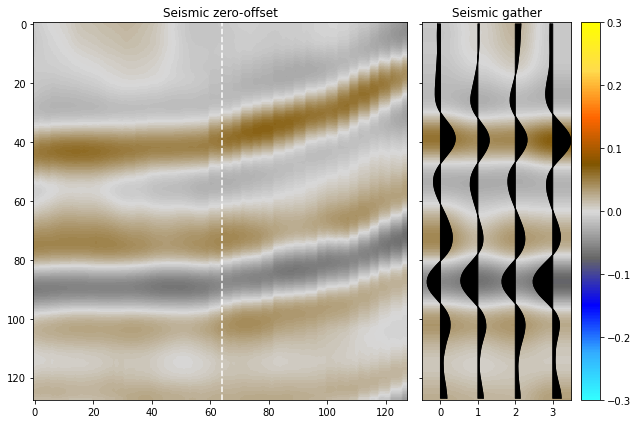

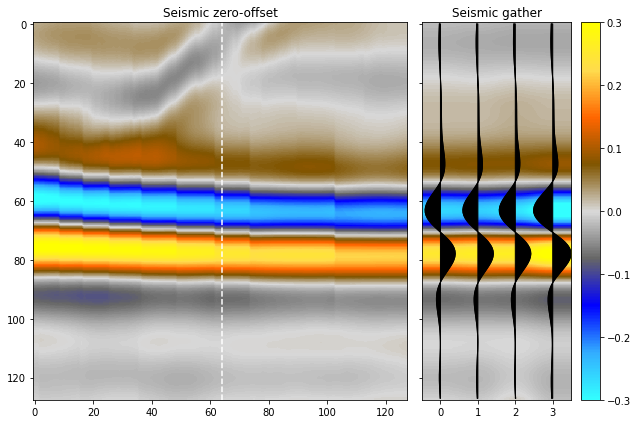

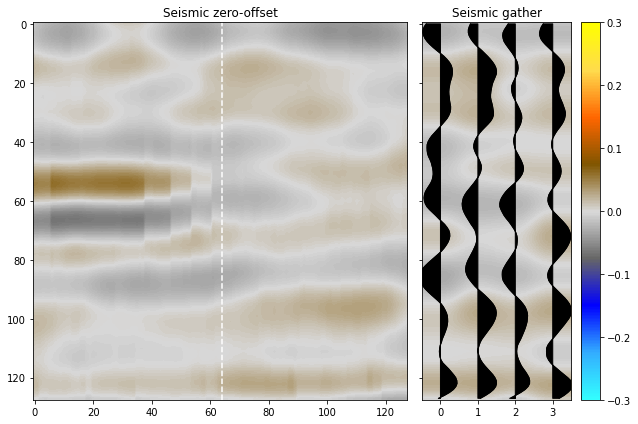

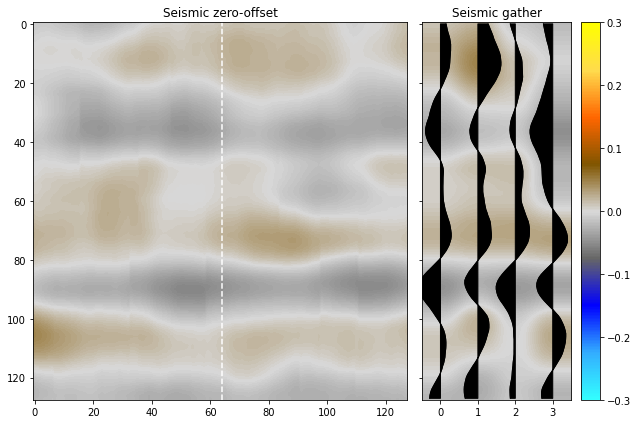

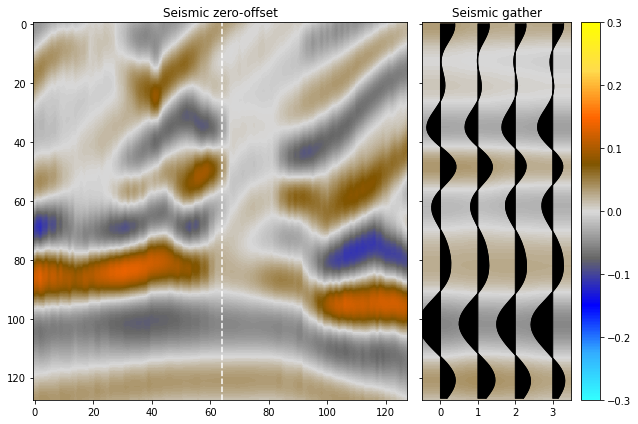

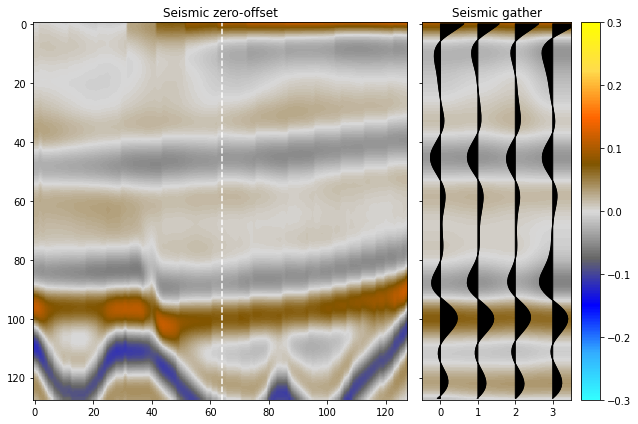

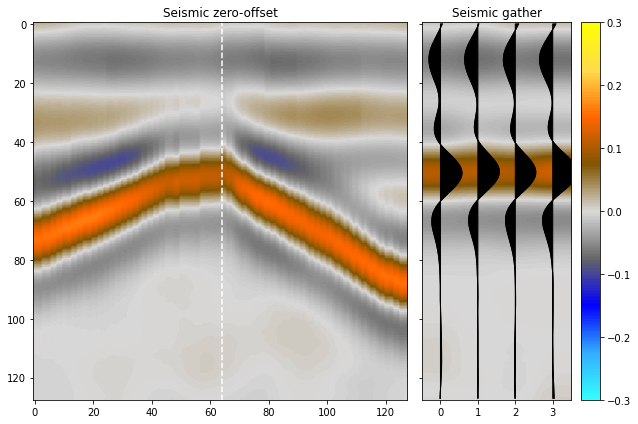

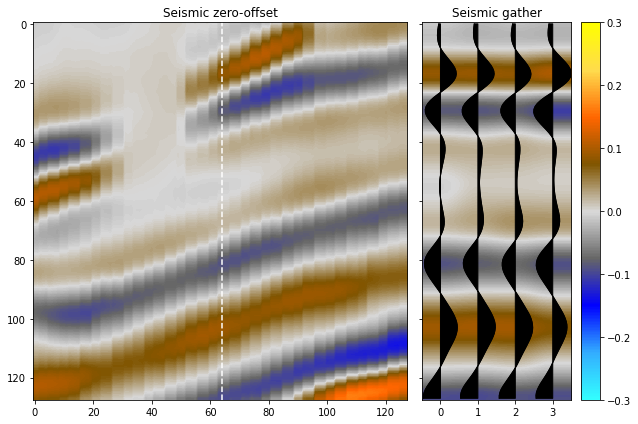

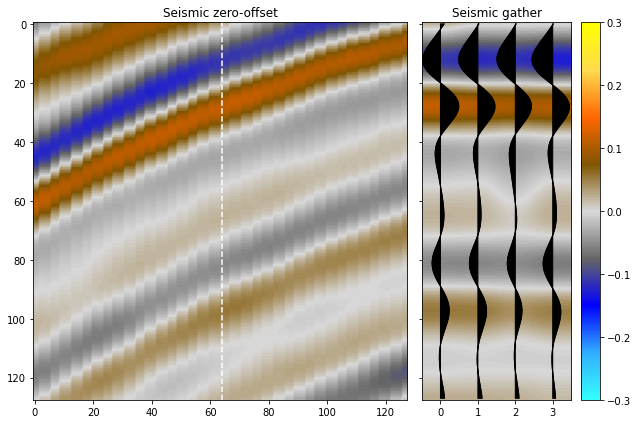

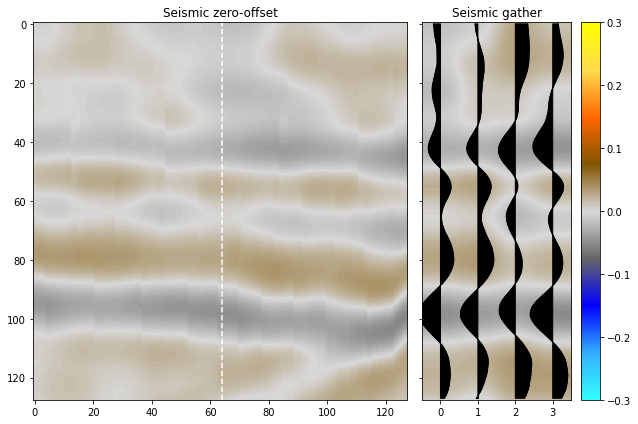

In [5]:
data_filenames = glob.glob(f'{datapath}/final/unlabelleddata/*npy')
suffixes_filenames = [filename.split('/')[-1][2:] for filename in data_filenames]

for idata in np.random.uniform(0, len(suffixes_filenames), 10).astype(np.int):
    data = np.load(f'{datapath}/final/unlabelleddata/d_{suffixes_filenames[idata]}').astype(np.float32)
    
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(9, 6), gridspec_kw={'width_ratios': [2, 1]})
    im = axs[0].imshow(data[...,0], cmap=cmap_seismic, vmin=-3e-1, vmax=3e-1)
    axs[0].axvline(64, color='w', linestyle='--')
    axs[0].set_title('Seismic zero-offset')
    axs[0].axis('tight')
    im = axs[1].imshow(data[:, 64], cmap=cmap_seismic, vmin=-3e-1, vmax=3e-1)
    wiggletracecomb(axs[1], np.arange(128), np.arange(4), data[:, 64].T, scaling=0.5,
                    cpos='k', cneg='k')
    axs[1].axis('tight')
    axs[1].set_xlim(-0.5, 3.5)
    axs[1].set_title('Seismic gather')
    plt.colorbar(im, ax=axs[1])
    plt.tight_layout()

## Testing data

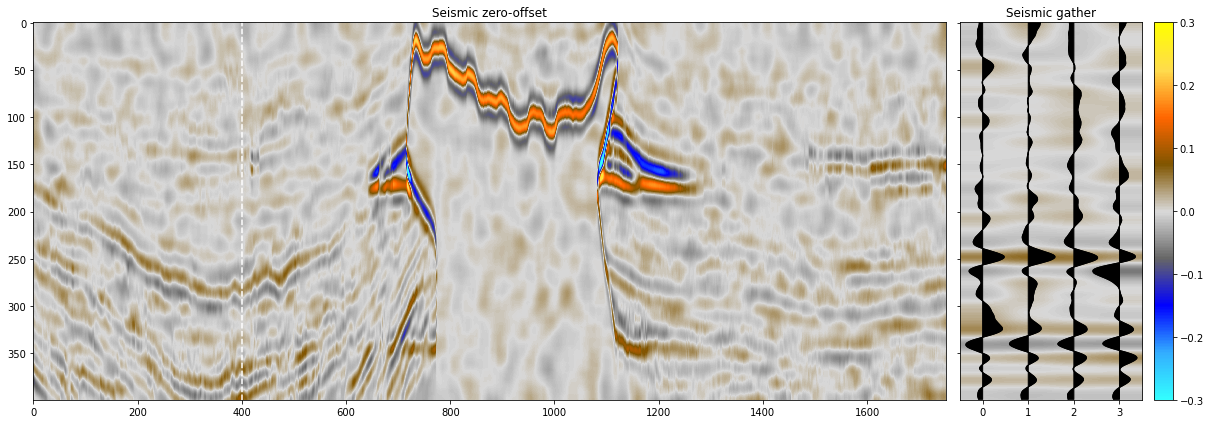

In [6]:
data = np.load(f'{datapath}/final/testdata/d2d.npy').astype(np.float32)
    
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(17, 6), gridspec_kw={'width_ratios': [4, 1]})
im = axs[0].imshow(data[0], cmap=cmap_seismic, vmin=-3e-1, vmax=3e-1)
axs[0].axvline(400, color='w', linestyle='--')
axs[0].set_title('Seismic zero-offset')
axs[0].axis('tight')
im = axs[1].imshow(data[:, :, 200].T, cmap=cmap_seismic, vmin=-3e-1, vmax=3e-1)
wiggletracecomb(axs[1], np.arange(400), np.arange(4), data[:, :, 200], scaling=0.5,
                cpos='k', cneg='k')
axs[1].axis('tight')
axs[1].set_xlim(-0.5, 3.5)
axs[1].set_title('Seismic gather')
plt.colorbar(im, ax=axs[1])
plt.tight_layout()